# Import modules, libraries

In [1]:
import pandas as pd
from pandas import Series, DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost.sklearn import XGBClassifier 
import xgboost

from sklearn.metrics import confusion_matrix

KFOLD = 5
RANDOM_SEED = 0

# Load datasets

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

# use total_df for data cleaning & feature engineering later on
total_df = pd.concat([train_df, test_df], ignore_index=True)

# Preview datasets

In [3]:
print('Training dataset columns & shapes:')
print(train_df.columns.values, train_df.shape)
print('-'*80)
print('Test dataset columns & shapes:')
print(test_df.columns.values, test_df.shape)
print('-'*80)
print('Peek train dataset')
train_df.head()

Training dataset columns & shapes:
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked'] (891, 12)
--------------------------------------------------------------------------------
Test dataset columns & shapes:
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked'] (418, 11)
--------------------------------------------------------------------------------
Peek train dataset


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## (1) Check features datatypes

In [4]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Numeric columns
- Survived, Pclass, Age, SibSp, Parch, Fare

### Non-numeric columns
- Name, Sex, Ticket, Cabin, Embarked

## (2) Check missing values

In [5]:
# Peak missing values

def get_missing_cols(dataframe):
    cols_with_missing_value = dataframe.columns[dataframe.isnull().any()].tolist()
    return cols_with_missing_value

print('Training missing values:')
print(train_df[get_missing_cols(train_df)].isnull().sum())
print('-'*80)
print('Test missing values:')
print(test_df[get_missing_cols(test_df)].isnull().sum())

Training missing values:
Age         177
Cabin       687
Embarked      2
dtype: int64
--------------------------------------------------------------------------------
Test missing values:
Age       86
Fare       1
Cabin    327
dtype: int64


## (3) Checking outliers

In [6]:
### Preview numeric features
total_df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


### Age, Fare, Parch, SibSp seem to have outliers

In [7]:
### Preview non-numeric features
print(train_df.describe(include=['O']))
print('-'*80)
print(test_df.describe(include=['O']))

                                               Name   Sex    Ticket Cabin  \
count                                           891   891       891   204   
unique                                          891     2       681   147   
top     Hart, Mrs. Benjamin (Esther Ada Bloomfield)  male  CA. 2343    G6   
freq                                              1   577         7     4   

       Embarked  
count       889  
unique        3  
top           S  
freq        644  
--------------------------------------------------------------------------------
                        Name   Sex    Ticket            Cabin Embarked
count                    418   418       418               91      418
unique                   418     2       363               76        3
top     Geiger, Miss. Amalie  male  PC 17608  B57 B59 B63 B66        S
freq                       1   266         5                3      270


### Observation
- male takes 65% (577/891)
- share tickets 23% (1 - 681/891)
- embarked 'S' taking 72% (644/889)

# Data correlation analysis

## (1) Numeric Features 

/opt/conda/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/opt/conda/lib/python3.6/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


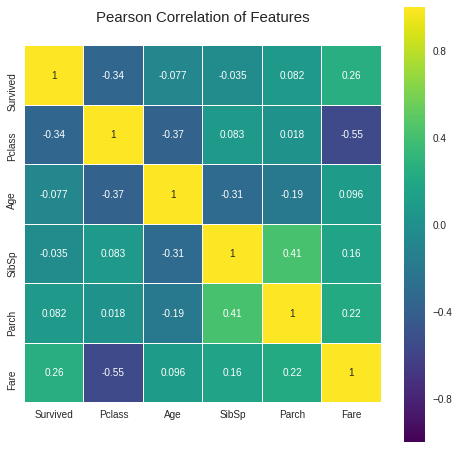

In [8]:
# Check correlations among numeric variables

numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

colormap = plt.cm.viridis
plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df[numeric_cols].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#sns.pairplot(train_df.drop("PassengerId", axis=1), hue="Survived", size=3)

### Observations:
#### correlated numeric features:
- Survived: Pclass & Fare
- Pclass: Fare & Age
- Age: SibSp & Parch
- SibSp: Parch
- Parch: Fare

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


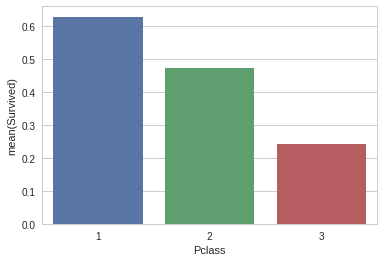

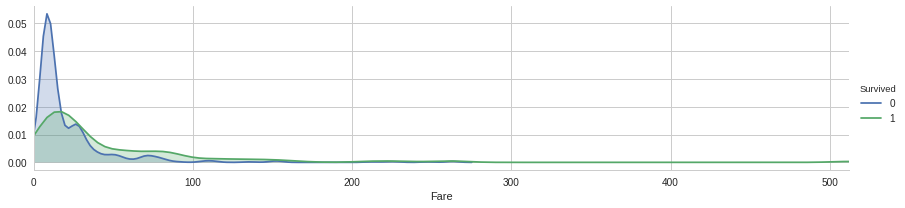

In [9]:
# Survived vs. Pclass & Fare

mean_survival_per_pclass = train_df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean()
sns.barplot(x='Pclass', y='Survived', data=mean_survival_per_pclass)

facet = sns.FacetGrid(train_df, hue="Survived", aspect=4)
facet.map(sns.kdeplot,'Fare', shade= True)
facet.set(xlim=(0, train_df['Fare'].max()))
facet.add_legend()


- Pclass & Fare are highly related to Survived
- List Pclass & Fare as important candidate features
- Revisit: 
    - Pclass & Fare are highly related, perhaps just keep one (Pclass), which has highest correlation with Survived

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


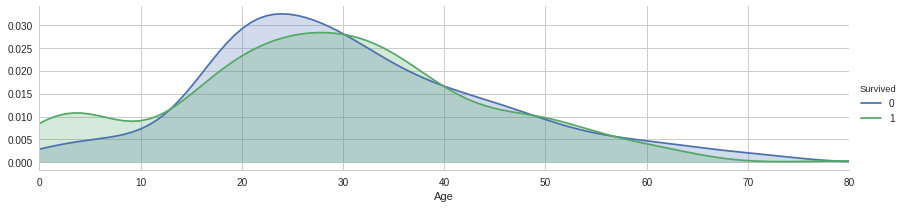

In [10]:
# Survived vs. Age
facet = sns.FacetGrid(train_df,hue="Survived", aspect=4)
facet.map(sns.kdeplot,'Age', shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()

- Age under 10 has higher survived ratio in Pclass 2 & 3. List 'Child'(age < 10) as a candidate feature.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


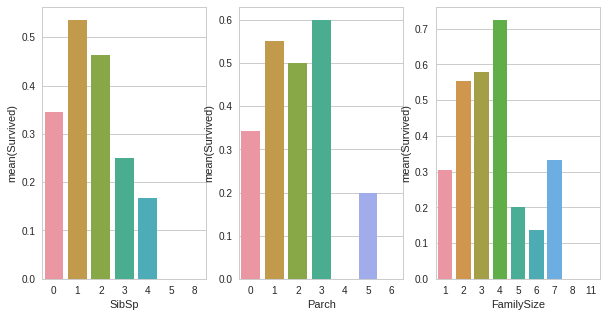

In [11]:
# Survived vs. SibSp & Parch
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10,5))

mean_survival_per_sibsp = train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean()
sns.barplot(x='SibSp', y='Survived', data=mean_survival_per_sibsp, ax=axis1)
mean_survival_per_parch = train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean()
sns.barplot(x='Parch', y='Survived', data=mean_survival_per_parch, ax=axis2)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
mean_survival_per_parch = train_df[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean()
sns.barplot(x='FamilySize', y='Survived', data=mean_survival_per_parch, ax=axis3)

- There are different partitions for SibSp & Parch with regarding to survived ratio.
- Perhaps combine them as a single feature (FamilySize), which might serve as a better partitions (say [1], [2,3,4], [>=5])

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-pa

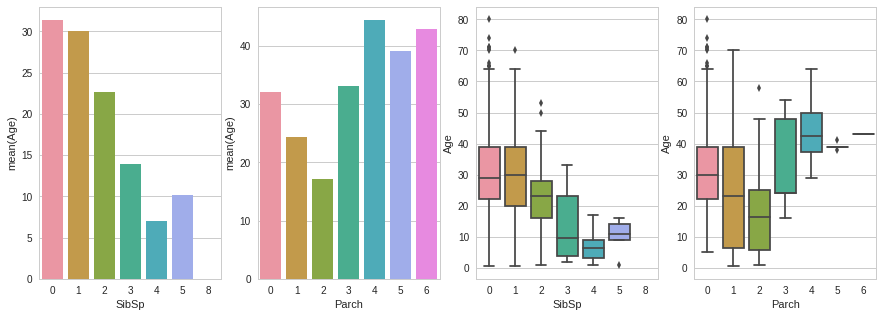

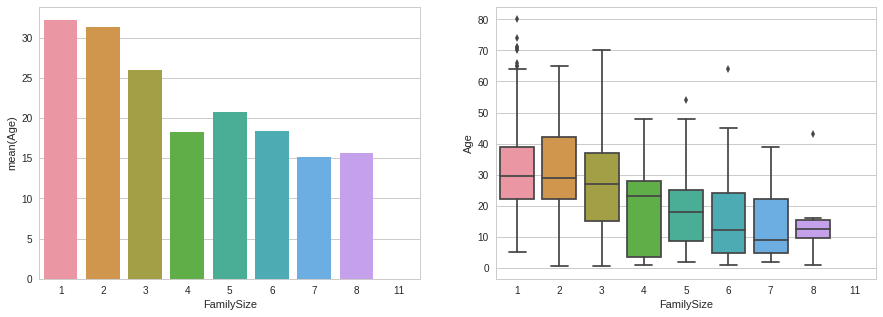

In [12]:
# SibSp, Parch, Age
fig, (axis1, axis2, axis3, axis4) = plt.subplots(1, 4, figsize=(15,5))

mean_age_per_sibsp = train_df[["SibSp", "Age"]].groupby(['SibSp'], as_index=False).mean()
sns.barplot(x='SibSp', y='Age', data=mean_age_per_sibsp, ax=axis1)
mean_age_per_parch = train_df[["Parch", "Age"]].groupby(['Parch'], as_index=False).mean()
sns.barplot(x='Parch', y='Age', data=mean_age_per_parch, ax=axis2)

sns.boxplot(x='SibSp', y='Age', data=train_df, ax=axis3)
sns.boxplot(x='Parch', y='Age', data=train_df, ax=axis4)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))
mean_age_per_parch = train_df[["FamilySize", "Age"]].groupby(['FamilySize'], as_index=False).mean()
sns.barplot(x='FamilySize', y='Age', data=mean_age_per_parch, ax=axis1)
sns.boxplot(x='FamilySize', y='Age', data=train_df, ax=axis2)


- Age distribution is quite different via SibSp & Parch
- Can't find good age distribution with FamilySize
- Consider to fill missing Age via distributions of SibSp & Parch, if no better Age correlation with non-numeric features explored later on.

In [13]:
train_df[['Age','SibSp','Parch']].dropna().groupby(['SibSp','Parch']).median()

Age
SibSp Parch      
0     0      29.5
      1      27.0
      2      20.5
      3      24.0
      4      29.0
      5      40.0
1     0      30.0
      1      30.5
      2      24.0
      3      48.0
      4      45.0
      5      39.0
      6      43.0
2     0      28.0
      1       4.0
      2      19.5
      3      24.0
3     0      31.5
      1       3.0
      2      10.0
4     1       7.0
      2       6.0
5     2      11.0

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


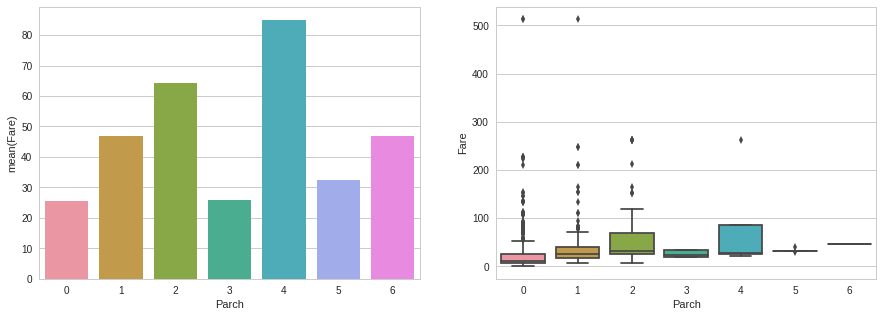

In [14]:
# Parch, Fare
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))

mean_fare_per_parch = train_df[["Parch", "Fare"]].groupby(['Parch'], as_index=False).mean()
sns.barplot(x='Parch', y='Fare', data=mean_fare_per_parch, ax=axis1)

sns.boxplot(x='Parch', y='Fare', data=train_df, ax=axis2)

- Consider to fill missing Fare via Pclass, ignore Parch.

## (2) Non-numeric Features

In [15]:
# Sex

def map_feature(dataset, feature, preprocess_func, mapping):
    if preprocess_func:
        dataset[feature] = dataset[feature].map(preprocess_func)
    if mapping:    
        dataset[feature] = dataset[feature].map(mapping)
    return dataset

sex_mapping = {'female': 1, 'male': 0}
train_df = map_feature(train_df, 'Sex', None, sex_mapping)

train_df[['Survived', 'Sex']].corr()

,Survived,Sex
Survived,1.000000,0.543351
Sex,0.543351,1.000000


- Sex is highly related to Survived, list it as a candidate feature

In [16]:
# Name

def transform_categorical_feature(dataset, feature, inplace=False):
    feature_dummies = pd.get_dummies(dataset[feature], prefix=feature)
    dataset = dataset.join(feature_dummies)
    if inplace:
        dataset.drop([feature], axis=1, inplace=True)
    return dataset

def get_dummies_cols_names(dataset, feature):
    cols = dataset.columns
    return list(filter(lambda col: col.startswith(feature + '_'), cols))

name_preprocess = (lambda name: name.split(',')[1].split('.')[0].strip())
title_mapping = {
                    "Capt":        "Officer",
                    "Col":         "Officer",
                    "Major":       "Officer",
                    "Jonkheer":    "Royalty",
                    "Don":         "Royalty",
                    "Sir" :        "Royalty",
                    "Dr":          "Officer",
                    "Rev":         "Officer",
                    "the Countess":"Royalty",
                    "Dona":        "Royalty",
                    "Mme":         "Mrs",
                    "Mlle":        "Miss",
                    "Ms":          "Mrs",
                    "Mr" :         "Mr",
                    "Mrs" :        "Mrs",
                    "Miss" :       "Miss",
                    "Master" :     "Master",
                    "Lady" :       "Royalty"
                }

train_df = map_feature(train_df, 'Name', name_preprocess, title_mapping)
train_df = transform_categorical_feature(train_df, 'Name', inplace=True)

cols = ['Survived']
cols.extend(get_dummies_cols_names(train_df, 'Name'))
train_df[cols].corr()

,Survived,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,Name_Royalty
Survived,1.000000,0.085221,0.332795,-0.549199,0.344935,-0.031316,0.033391
Name_Master,0.085221,1.000000,-0.110602,-0.254903,-0.088394,-0.031131,-0.016287
Name_Miss,0.332795,-0.110602,1.000000,-0.599803,-0.207996,-0.073253,-0.038324
Name_Mr,-0.549199,-0.254903,-0.599803,1.000000,-0.479363,-0.168826,-0.088324
Name_Mrs,0.344935,-0.088394,-0.207996,-0.479363,1.000000,-0.058544,-0.030628
Name_Officer,-0.031316,-0.031131,-0.073253,-0.168826,-0.058544,1.000000,-0.010787
Name_Royalty,0.033391,-0.016287,-0.038324,-0.088324,-0.030628,-0.010787,1.000000


- Miss & Mrs & Mr are highly related to Survived

In [17]:
# Ticket

# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def clean_ticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

# Extracting dummy variables from tickets:
train_df = map_feature(train_df, 'Ticket', clean_ticket, None)
train_df = transform_categorical_feature(train_df, 'Ticket', inplace=True)

cols = ['Survived']
cols.extend(get_dummies_cols_names(train_df, 'Ticket'))
train_df[cols].corr()

,Survived,Ticket_A4,Ticket_A5,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,...,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
Survived,1.000000,-0.070234,-0.092199,-0.026456,0.002496,-0.019137,-0.026456,-0.026456,0.064285,-0.026456,...,-0.045876,-0.037436,-0.067404,-0.026456,0.007887,0.019667,0.060095,-0.062182,-0.006036,0.001492
Ticket_A4,-0.070234,1.000000,-0.013825,-0.002983,-0.006685,-0.019544,-0.002983,-0.002983,-0.006685,-0.002983,...,-0.005172,-0.004221,-0.011644,-0.002983,-0.010397,-0.007327,-0.004221,-0.009481,-0.005172,-0.150855
Ticket_A5,-0.092199,-0.013825,1.000000,-0.005208,-0.011671,-0.034122,-0.005208,-0.005208,-0.011671,-0.005208,...,-0.009030,-0.007369,-0.020330,-0.005208,-0.018153,-0.012792,-0.007369,-0.016552,-0.009030,-0.263382
Ticket_AS,-0.026456,-0.002983,-0.005208,1.000000,-0.002518,-0.007362,-0.001124,-0.001124,-0.002518,-0.001124,...,-0.001948,-0.001590,-0.004386,-0.001124,-0.003917,-0.002760,-0.001590,-0.003571,-0.001948,-0.056825
Ticket_C,0.002496,-0.006685,-0.011671,-0.002518,1.000000,-0.016499,-0.002518,-0.002518,-0.005643,-0.002518,...,-0.004366,-0.003563,-0.009830,-0.002518,-0.008777,-0.006185,-0.003563,-0.008004,-0.004366,-0.127352
Ticket_CA,-0.019137,-0.019544,-0.034122,-0.007362,-0.016499,1.000000,-0.007362,-0.007362,-0.016499,-0.007362,...,-0.012765,-0.010417,-0.028739,-0.007362,-0.025661,-0.018084,-0.010417,-0.023399,-0.012765,-0.372322
Ticket_CASOTON,-0.026456,-0.002983,-0.005208,-0.001124,-0.002518,-0.007362,1.000000,-0.001124,-0.002518,-0.001124,...,-0.001948,-0.001590,-0.004386,-0.001124,-0.003917,-0.002760,-0.001590,-0.003571,-0.001948,-0.056825
Ticket_FC,-0.026456,-0.002983,-0.005208,-0.001124,-0.002518,-0.007362,-0.001124,1.000000,-0.002518,-0.001124,...,-0.001948,-0.001590,-0.004386,-0.001124,-0.003917,-0.002760,-0.001590,-0.003571,-0.001948,-0.056825
Ticket_FCC,0.064285,-0.006685,-0.011671,-0.002518,-0.005643,-0.016499,-0.002518,-0.002518,1.000000,-0.002518,...,-0.004366,-0.003563,-0.009830,-0.002518,-0.008777,-0.006185,-0.003563,-0.008004,-0.004366,-0.127352
Ticket_Fa,-0.026456,-0.002983,-0.005208,-0.001124,-0.002518,-0.007362,-0.001124,-0.001124,-0.002518,1.000000,...,-0.001948,-0.001590,-0.004386,-0.001124,-0.003917,-0.002760,-0.001590,-0.003571,-0.001948,-0.056825


- No obvious correlation, only Ticket_PC gets higher correlation
- Should we consider to probe sharing tickets?
- Revisit:
    - Consider drop these features?

In [18]:
# Cabin (lots of missing values, very few duplications)

# replacing missing cabins with U (for Uknown)
train_df['Cabin'].fillna('U', inplace=True)

extract_cabin = (lambda c: c[0])
train_df = map_feature(train_df, 'Cabin', extract_cabin, None)
train_df = transform_categorical_feature(train_df, 'Cabin', inplace=True)

cols = ['Survived']
cols.extend(get_dummies_cols_names(train_df, 'Cabin'))
train_df[cols].corr()    

,Survived,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
Survived,1.000000,0.022287,0.175095,0.114652,0.150716,0.145321,0.057935,0.016040,-0.026456,-0.316912
Cabin_A,0.022287,1.000000,-0.030880,-0.034846,-0.025663,-0.025256,-0.015923,-0.008787,-0.004386,-0.240136
Cabin_B,0.175095,-0.030880,1.000000,-0.062841,-0.046280,-0.045547,-0.028715,-0.015847,-0.007910,-0.433053
Cabin_C,0.114652,-0.034846,-0.062841,1.000000,-0.052225,-0.051398,-0.032403,-0.017883,-0.008926,-0.488683
Cabin_D,0.150716,-0.025663,-0.046280,-0.052225,1.000000,-0.037852,-0.023864,-0.013170,-0.006574,-0.359896
Cabin_E,0.145321,-0.025256,-0.045547,-0.051398,-0.037852,1.000000,-0.023486,-0.012961,-0.006470,-0.354194
Cabin_F,0.057935,-0.015923,-0.028715,-0.032403,-0.023864,-0.023486,1.000000,-0.008171,-0.004079,-0.223299
Cabin_G,0.016040,-0.008787,-0.015847,-0.017883,-0.013170,-0.012961,-0.008171,1.000000,-0.002251,-0.123234
Cabin_T,-0.026456,-0.004386,-0.007910,-0.008926,-0.006574,-0.006470,-0.004079,-0.002251,1.000000,-0.061513
Cabin_U,-0.316912,-0.240136,-0.433053,-0.488683,-0.359896,-0.354194,-0.223299,-0.123234,-0.061513,1.000000


- Some cabin classes have better survived ratio, while unknown cabin has bad survived ratio
- List cabin one-hot encoding feature as candidate features
- Revisit:
    - Perhaps try (1) drop these features (2) keep 2 classes only, known & unknown cabins

S    644
C    168
Q     77
Name: Embarked, dtype: int64


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


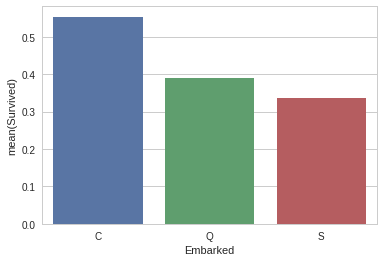

In [19]:
# Embarked

print(train_df['Embarked'].value_counts())
mean_survival_per_embark = train_df[["Survived", "Embarked"]].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=mean_survival_per_embark)

- Embarked is related to Survived, list it as a candidate feature

# Deal with missing values

## Hereafter, we'll perform transformation on total_df, while exploring on train_df if needed

In [20]:
# since we'd perform transformation on total_df, 
# we need to apply those transformation we did during data exploration phase (applied on train_df).

total_df = map_feature(total_df, 'Sex', None, sex_mapping)
total_df = map_feature(total_df, 'Name', name_preprocess, title_mapping)
total_df = transform_categorical_feature(total_df, 'Name', inplace=False) # keep 'Name' 
total_df = map_feature(total_df, 'Ticket', clean_ticket, None)
total_df = transform_categorical_feature(total_df, 'Ticket', inplace=True)
total_df['Cabin'].fillna('U', inplace=True)
total_df = map_feature(total_df, 'Cabin', extract_cabin, None)
total_df = transform_categorical_feature(total_df, 'Cabin', inplace=True)

In [21]:
# Embarked (2 missings)

total_df[total_df['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Ticket_XXX,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
61,38.0,NaN,80.0,Miss,0,62,1,1,0,1.0,...,1,0,1,0,0,0,0,0,0,0
829,62.0,NaN,80.0,Mrs,0,830,1,1,0,1.0,...,1,0,1,0,0,0,0,0,0,0


- The two persons lacking of Embarked value are all Pclass=1 & Fare=80.0, try to check Pclass/Fare/Embarked 

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


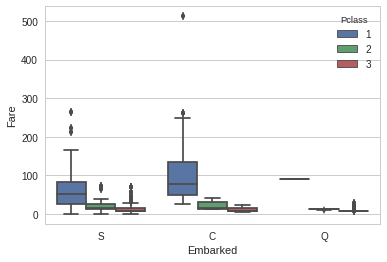

In [22]:
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=total_df)

- Embarked 'C' seems to be a good fit for Pclass=1 & Fare=80.0

In [23]:
total_df['Embarked'].fillna('C', inplace=True)
total_df = transform_categorical_feature(total_df, 'Embarked', inplace=True)

cols = ['Survived']
cols.extend(get_dummies_cols_names(total_df, 'Embarked'))
total_df[cols].corr() 

,Survived,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,0.174718,0.003650,-0.155660
Embarked_C,0.174718,1.000000,-0.164932,-0.779058
Embarked_Q,0.003650,-0.164932,1.000000,-0.489874
Embarked_S,-0.155660,-0.779058,-0.489874,1.000000


In [24]:
# Check age with so-far important features

cols = ['Age', 'Sex', 'Pclass', 'SibSp', 'Parch']
cols.extend(get_dummies_cols_names(total_df, 'Name'))
total_df[cols].corr()

,Age,Sex,Pclass,SibSp,Parch,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,Name_Royalty
Age,1.000000,-0.063645,-0.408106,-0.243699,-0.150917,-0.391259,-0.282977,0.183965,0.215091,0.166771,0.059500
Sex,-0.063645,1.000000,-0.124617,0.109609,0.213125,-0.164375,0.672819,-0.870678,0.571176,-0.087288,0.020408
Pclass,-0.408106,-0.124617,1.000000,0.060832,0.018322,0.095257,0.024487,0.121492,-0.179945,-0.137341,-0.104916
SibSp,-0.243699,0.109609,0.060832,1.000000,0.373587,0.329171,0.077564,-0.243104,0.061643,-0.013813,-0.010787
Parch,-0.150917,0.213125,0.018322,0.373587,1.000000,0.253482,0.066473,-0.304780,0.213491,-0.032631,-0.030197
Name_Master,-0.391259,-0.164375,0.095257,0.329171,0.253482,1.000000,-0.110595,-0.258902,-0.093887,-0.029567,-0.015002
Name_Miss,-0.282977,0.672819,0.024487,0.077564,0.066473,-0.110595,1.000000,-0.585809,-0.212435,-0.066899,-0.033945
Name_Mr,0.183965,-0.870678,0.121492,-0.243104,-0.304780,-0.258902,-0.585809,1.000000,-0.497310,-0.156611,-0.079466
Name_Mrs,0.215091,0.571176,-0.179945,0.061643,0.213491,-0.093887,-0.212435,-0.497310,1.000000,-0.056793,-0.028817
Name_Officer,0.166771,-0.087288,-0.137341,-0.013813,-0.032631,-0.029567,-0.066899,-0.156611,-0.056793,1.000000,-0.009075


- Age distribution is related to Pclass, SibSp, Name_dummies_features

In [25]:
# Fill missing values of age with median (combined train + test)
age_matrix1 = total_df[['Age','Pclass','Name','SibSp']].dropna().groupby(['Pclass', 'Name', 'SibSp']).median()
print(age_matrix1)
age_matrix2 = total_df[['Age','Pclass','Name']].dropna().groupby(['Pclass', 'Name']).median()
print(age_matrix2)


def fill_ages(dataset):
    for index, row in dataset[dataset['Age'].isnull()].iterrows():
        pcls, title, sibsp = row['Pclass'], row['Name'], row['SibSp']
        try:
            median_age = age_matrix1.loc[pcls, title, sibsp].values
        except KeyError:
#             print(pcls, title, sibsp)
            median_age = age_matrix2.loc[pcls, title].values
        dataset.loc[index, 'Age'] = median_age
#         print('idx %d: fill %f (pcls=%d, title=%s, sibsp=%d)' % (index, median_age, pcls, title, sibsp))
    return dataset

total_df = fill_ages(total_df)

                        Age
Pclass Name    SibSp       
1      Master  0       5.00
               1       5.96
               2      13.00
       Miss    0      30.00
               1      32.00
               2      19.50
               3      24.00
       Mr      0      41.00
               1      42.00
               3      19.00
       Mrs     0      51.00
               1      39.00
               2      55.00
       Officer 0      52.00
               1      53.00
               2      47.00
       Royalty 0      38.50
               1      48.50
2      Master  0       1.00
               1       2.00
               2       1.00
       Miss    0      24.00
               1      13.00
               2      12.00
       Mr      0      29.50
               1      32.50
               2      23.50
       Mrs     0      33.50
               1      29.00
               2      24.00
               3      30.00
       Officer 0      41.50
               1      42.00
3      Master  0    

In [26]:
## Fill missing value of Fare in test

print(total_df['Pclass'][total_df['Fare'].isnull()])

mean_fare_pclass_3 = total_df[['Fare', 'Pclass']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=False).values[0][1]
total_df['Fare'].fillna(mean_fare_pclass_3, inplace=True)

1043    3
Name: Pclass, dtype: int64


In [27]:
print(total_df[get_missing_cols(total_df)].isnull().sum())

Survived    418
dtype: int64


- missing 418 Survived is expected for test data 

## No missing values now, let's do some feature engineering

In [28]:
## SibSp & Parch => FamilySize

total_df['FamilySize'] = total_df['SibSp'] + total_df['Parch'] + 1

# total_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)
total_df['Singleton'] = total_df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
total_df['SmallFamily'] = total_df['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
total_df['LargeFamily'] = total_df['FamilySize'].map(lambda s: 1 if 5<=s else 0)

total_df.drop(['SibSp', 'Parch', 'FamilySize'], axis=1, inplace=True)


In [29]:
## Add Child

total_df['Child'] = total_df['Age'].map(lambda s: 1 if s <= 10 else 0)

## Drop Name
total_df.drop(['Name'], axis=1, inplace=True)

## Drop PassengerId
total_df.drop(['PassengerId'], axis=1, inplace=True)

In [30]:
total_df.head()

,Age,Fare,Pclass,Sex,Survived,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,...,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Singleton,SmallFamily,LargeFamily,Child
0,22.0,7.2500,3,0,0.0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
1,38.0,71.2833,1,1,1.0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,26.0,7.9250,3,1,1.0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,35.0,53.1000,1,1,1.0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,35.0,8.0500,3,0,0.0,0,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0


In [41]:
total_df.columns

Index(['Age', 'Fare', 'Pclass', 'Sex', 'Survived', 'Name_Master', 'Name_Miss',
       'Name_Mr', 'Name_Mrs', 'Name_Officer', 'Name_Royalty', 'Ticket_A',
       'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3', 'Ticket_AQ4', 'Ticket_AS',
       'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON', 'Ticket_FC', 'Ticket_FCC',
       'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP', 'Ticket_PC', 'Ticket_PP',
       'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3', 'Ticket_SCA4', 'Ticket_SCAH',
       'Ticket_SCOW', 'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC',
       'Ticket_SOP', 'Ticket_SOPP', 'Ticket_SOTONO2', 'Ticket_SOTONOQ',
       'Ticket_SP', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_STONOQ',
       'Ticket_SWPP', 'Ticket_WC', 'Ticket_WEP', 'Ticket_XXX', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Singleton', 'SmallFamily', 'LargeFamily', 'Child'],
      dtype='object')

In [45]:
# drop Ticket_ dummies
drop_cols = [col for col in total_df.columns.values if 'Ticket_' in col]
# drop Fare
drop_cols.append('Fare')

total_df.drop(drop_cols, axis=1, inplace=True)

In [48]:
train_txf_df = total_df.head(891)
test_txf_df = total_df.iloc[891:]
train_txf_target = train_txf_df['Survived']
train_txf_df.drop(['Survived'], axis=1, inplace=True)
test_txf_df.drop(['Survived'], axis=1, inplace=True)

print(train_txf_df.shape, test_txf_df.shape, train_txf_target.shape)

(891, 25) (418, 25) (891,)


# Feature Scaling

In [49]:
from sklearn import preprocessing

std_scaler = preprocessing.StandardScaler().fit(train_txf_df[['Age']])
train_txf_df[['Age']] = std_scaler.transform(train_txf_df[['Age']])
test_txf_df[['Age']] = std_scaler.transform(test_txf_df[['Age']])

# Revisit: drop Fare
# robust_scaler = preprocessing.RobustScaler().fit(train_txf_df[['Fare']])
# train_txf_df[['Fare']] = robust_scaler.transform(train_txf_df[['Fare']])
# test_txf_df[['Fare']] = robust_scaler.transform(test_txf_df[['Fare']])

train_txf_df.head()

,Age,Pclass,Sex,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,Name_Royalty,Cabin_A,...,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Singleton,SmallFamily,LargeFamily,Child
0,-0.526807,3,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0.651319,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.232276,3,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,0.430420,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0.430420,3,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


# Model Selection

In [50]:
# Helper for cross_validataion evaluation
def compute_cv_score(clf, X, y, scoring='accuracy'):
    skf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=RANDOM_SEED)
    xval = cross_val_score(clf, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    print('  CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g' % 
          (np.mean(xval), np.std(xval), np.min(xval), np.max(xval)))

# Helper for choosing best GridSearchCV model
def get_best_cv_model(estimator, train, target, parameter_grid, scoring='accuracy', show='False'):
    skf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=RANDOM_SEED)
    clf = GridSearchCV(estimator,
                       param_grid=parameter_grid,
                       cv=skf,
                       scoring=scoring,
                       n_jobs=-1)
    clf.fit(train, target)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    print('  KFold: %d' % clf.n_splits_)
    print('  Best score: {}'.format(clf.best_score_))
    print('  Best parameters: {}'.format(clf.best_params_))
    if show:
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("  [%0.7f (+/-%0.07f) for %r]" % (mean, std * 2, params))    
    return clf.best_estimator_
    
# Helper for confusion_matrix plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Helper for plotting feature importance
def plot_feature_importance(features, importance):
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = features
    feature_importance['importance'] = importance
    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(15, 10))
    feature_importance.plot(kind='bar', title='Feature Importances', ax=ax, x='feature')
    plt.ylabel('Feature Importance Score')

## (1) RandomForest ([RandomForest Hyperparameters tuning guide](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/))

Accuracy:
  CV Score : Mean - 0.8193249 | Std - 0.02755053 | Min - 0.7709497 | Max - 0.8547486
F1:
  CV Score : Mean - 0.7526196 | Std - 0.03559302 | Min - 0.6962963 | Max - 0.8088235


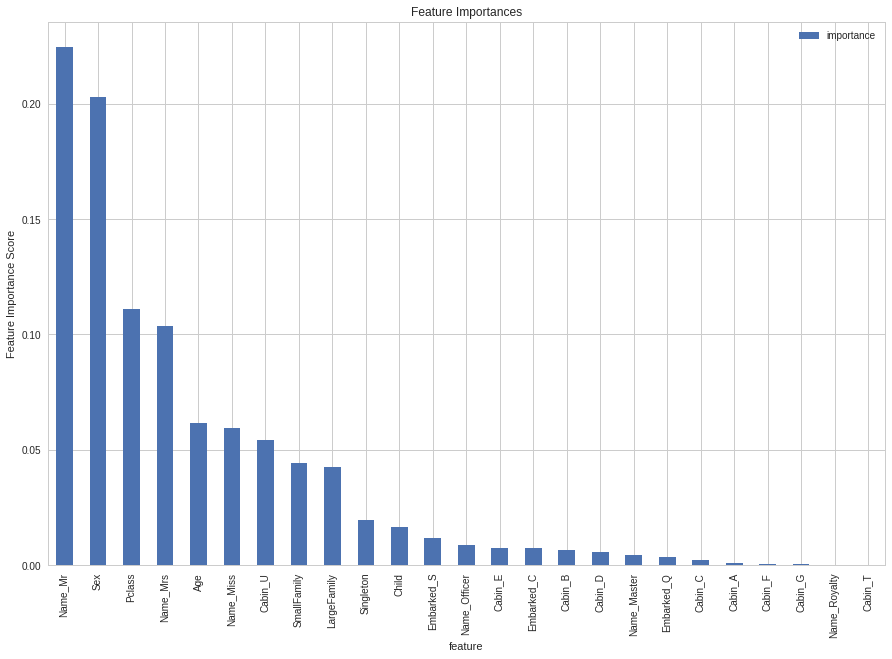

In [51]:
# (1) Preset, as baseline
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
              'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6,
              'random_state': RANDOM_SEED}
rf = RandomForestClassifier(**parameters)
rf.fit(train_txf_df, train_txf_target)


print('Accuracy:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='f1')

plot_feature_importance(train_txf_df.columns, rf.feature_importances_)

In [52]:
# 3 major parameters to tune: max_features, n_estimators, min_sample_leaf

rf = RandomForestClassifier(bootstrap=False, n_jobs=-1, random_state=RANDOM_SEED)
parameter_grid = {
                  'n_estimators': [50, 75, 100, 125, 150, 175, 200],
                  'min_samples_leaf': [5, 10, 25, 50], # 50, imbalance data uses smaller value
                  'min_samples_split': [10, 25, 50, 75],
                  'max_depth' : [5, 6, 7, 8], # 5~8
                 }

rf = get_best_cv_model(rf, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=False)
print('Accuracy:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8294051627384961
  Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 25, 'n_estimators': 125}
Accuracy:
  CV Score : Mean - 0.8294438 | Std - 0.02990445 | Min - 0.7765363 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7625759 | Std - 0.03890901 | Min - 0.7014925 | Max - 0.8208955


In [53]:
parameter_grid = {
                  'min_samples_split': [20, 25, 30],
                  'max_depth' : [8, 9, 10] # 3~10
                 }

rf = get_best_cv_model(rf, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=False)
print('Accuracy:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8294051627384961
  Best parameters: {'max_depth': 8, 'min_samples_split': 25}
Accuracy:
  CV Score : Mean - 0.8294438 | Std - 0.02990445 | Min - 0.7765363 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7625759 | Std - 0.03890901 | Min - 0.7014925 | Max - 0.8208955


Accuracy:
  CV Score : Mean - 0.8294438 | Std - 0.02990445 | Min - 0.7765363 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7625759 | Std - 0.03890901 | Min - 0.7014925 | Max - 0.8208955


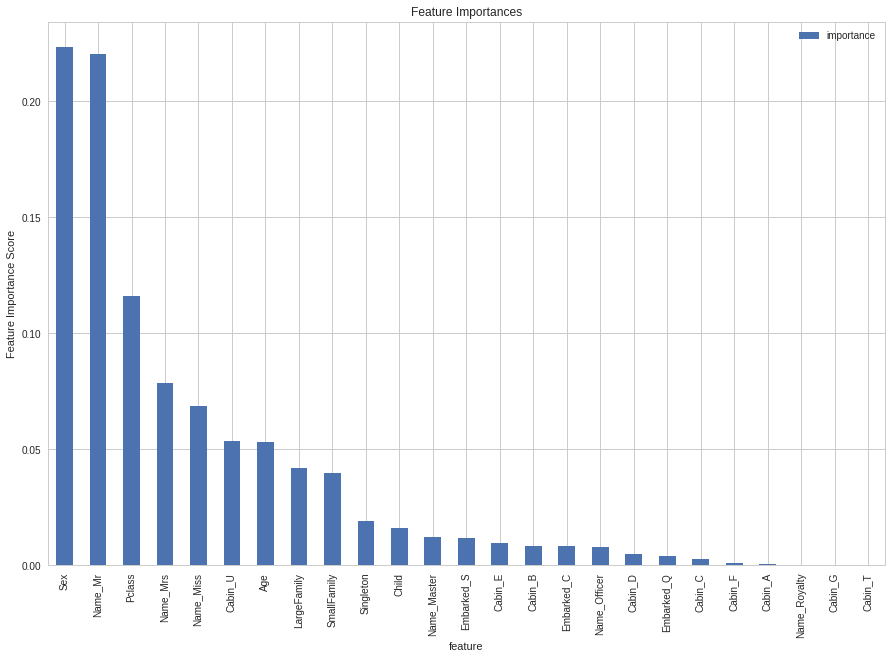

In [54]:
print('Accuracy:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(rf, train_txf_df, train_txf_target, scoring='f1')
plot_feature_importance(train_txf_df.columns, rf.feature_importances_)

Confusion matrix, without normalization
[[501  48]
 [ 87 255]]


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

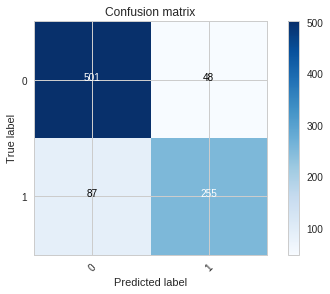

In [55]:
pred = rf.predict(train_txf_df)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

rf

- The submission score is 0.79426 (7/23) [63 features]
- The submission score is 0.79426 (7/27) [25 features]

## (2) XGBoost ([eXtreme Gradient Boosting Hyperparameters tuning guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/))

In [59]:
# (1) Start from suggested parameters to get the baseline
#     - max_depth = 5 : This should be between 3-10. 4-6 can be good starting points.
#     - min_child_weight = 5 
#     - gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
#     - subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values in 0.5-0.9.
#     - scale_pos_weight = 1

def modelfit(booster, dtrain, target, cv_folds=KFOLD, early_stopping_rounds=100):
    xgb_param = booster.get_xgb_params()
    xgtrain = xgboost.DMatrix(dtrain.values, label=target.values)
    cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=booster.get_params()['n_estimators'], 
                          nfold=cv_folds, seed=RANDOM_SEED, early_stopping_rounds=early_stopping_rounds)
    booster.set_params(n_estimators=cvresult.shape[0])
    print('n_estimators = %d'%cvresult.shape[0])
    return booster
    

xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=-1,
                    scale_pos_weight=1,
                    seed=RANDOM_SEED)

xgb = modelfit(xgb, train_txf_df, train_txf_target)
print('Accuracy:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

n_estimators = 59
Accuracy:
  CV Score : Mean - 0.8271839 | Std - 0.02753702 | Min - 0.7765363 | Max - 0.8603352
F1:
  CV Score : Mean - 0.7629656 | Std - 0.04024361 | Min - 0.6969697 | Max - 0.822695


In [60]:
# (2) Tune max_depth & min_child_weight

parameter_grid = {
    'max_depth': [3, 4, 5, 6, 7], # 3 ~ 10
    'min_child_weight': [5, 10, 25, 50] # A smaller value for imbalanced class
}

xgb = get_best_cv_model(xgb, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8271604938271605
  Best parameters: {'max_depth': 5, 'min_child_weight': 5}
  [0.8237935 (+/-0.0551976) for {'max_depth': 3, 'min_child_weight': 5}]
  [0.8170595 (+/-0.0536434) for {'max_depth': 3, 'min_child_weight': 10}]
  [0.8069585 (+/-0.0585198) for {'max_depth': 3, 'min_child_weight': 25}]
  [0.7845118 (+/-0.0804699) for {'max_depth': 3, 'min_child_weight': 50}]
  [0.8215488 (+/-0.0605350) for {'max_depth': 4, 'min_child_weight': 5}]
  [0.8170595 (+/-0.0504894) for {'max_depth': 4, 'min_child_weight': 10}]
  [0.8069585 (+/-0.0585198) for {'max_depth': 4, 'min_child_weight': 25}]
  [0.7845118 (+/-0.0804699) for {'max_depth': 4, 'min_child_weight': 50}]
  [0.8271605 (+/-0.0551919) for {'max_depth': 5, 'min_child_weight': 5}]
  [0.8148148 (+/-0.0474451) for {'max_depth': 5, 'min_child_weight': 10}]
  [0.8069585 (+/-0.0585198) for {'max_depth': 5, 'min_child_weight': 25}]
  [0.7845118 (+/-0.0804699) for {'max_depth': 5, 'min_child_weight': 50}]
  [0.8237935

In [61]:
# (3) Tune gamma

parameter_grid = {
    'gamma': [i/10.0 for i in range(0, 5)]
}

xgb = get_best_cv_model(xgb, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')
xgb

  KFold: 5
  Best score: 0.8282828282828283
  Best parameters: {'gamma': 0.1}
  [0.8271605 (+/-0.0551919) for {'gamma': 0.0}]
  [0.8282828 (+/-0.0551322) for {'gamma': 0.1}]
  [0.8260382 (+/-0.0534104) for {'gamma': 0.2}]
  [0.8249158 (+/-0.0648346) for {'gamma': 0.3}]
  [0.8249158 (+/-0.0606397) for {'gamma': 0.4}]
Accuracy
  CV Score : Mean - 0.8282823 | Std - 0.02750999 | Min - 0.7877095 | Max - 0.8715084
F1:
  CV Score : Mean - 0.7615306 | Std - 0.04219454 | Min - 0.7121212 | Max - 0.8345324


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=59, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.8)

In [62]:
# Recalibrate the number of boosting rounds for the updated parameters.
# reset n_estimators to 1000 to get new n_estimators

xgb.set_params(n_estimators=1000)
xgb = modelfit(xgb, train_txf_df, train_txf_target)

print('Accuracy:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

xgb

n_estimators = 71
Accuracy:
  CV Score : Mean - 0.8338941 | Std - 0.02681271 | Min - 0.7932961 | Max - 0.877095
F1:
  CV Score : Mean - 0.7708076 | Std - 0.03906859 | Min - 0.7218045 | Max - 0.8405797


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=71, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.8)

In [63]:
# (4) Tune subsample and colsample_bytree

parameter_grid = {
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

xgb = get_best_cv_model(xgb, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'colsample_bytree': 0.6, 'subsample': 0.7}
  [0.8271605 (+/-0.0657115) for {'colsample_bytree': 0.6, 'subsample': 0.6}]
  [0.8338945 (+/-0.0619161) for {'colsample_bytree': 0.6, 'subsample': 0.7}]
  [0.8271605 (+/-0.0662283) for {'colsample_bytree': 0.6, 'subsample': 0.8}]
  [0.8282828 (+/-0.0777770) for {'colsample_bytree': 0.6, 'subsample': 0.9}]
  [0.8282828 (+/-0.0686959) for {'colsample_bytree': 0.7, 'subsample': 0.6}]
  [0.8282828 (+/-0.0643675) for {'colsample_bytree': 0.7, 'subsample': 0.7}]
  [0.8305275 (+/-0.0631554) for {'colsample_bytree': 0.7, 'subsample': 0.8}]
  [0.8294052 (+/-0.0644333) for {'colsample_bytree': 0.7, 'subsample': 0.9}]
  [0.8260382 (+/-0.0693041) for {'colsample_bytree': 0.8, 'subsample': 0.6}]
  [0.8294052 (+/-0.0517505) for {'colsample_bytree': 0.8, 'subsample': 0.7}]
  [0.8338945 (+/-0.0537421) for {'colsample_bytree': 0.8, 'subsample': 0.8}]
  [0.8249158 (+/-0.0592546) for {'colsample_by

In [64]:
parameter_grid = {
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bytree': [0.55, 0.6, 0.65]
}

xgb = get_best_cv_model(xgb, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'colsample_bytree': 0.6, 'subsample': 0.7}
  [0.8260382 (+/-0.0651186) for {'colsample_bytree': 0.55, 'subsample': 0.65}]
  [0.8271605 (+/-0.0613126) for {'colsample_bytree': 0.55, 'subsample': 0.7}]
  [0.8260382 (+/-0.0543466) for {'colsample_bytree': 0.55, 'subsample': 0.75}]
  [0.8271605 (+/-0.0510225) for {'colsample_bytree': 0.6, 'subsample': 0.65}]
  [0.8338945 (+/-0.0619161) for {'colsample_bytree': 0.6, 'subsample': 0.7}]
  [0.8271605 (+/-0.0516051) for {'colsample_bytree': 0.6, 'subsample': 0.75}]
  [0.8282828 (+/-0.0622502) for {'colsample_bytree': 0.65, 'subsample': 0.65}]
  [0.8327722 (+/-0.0490382) for {'colsample_bytree': 0.65, 'subsample': 0.7}]
  [0.8338945 (+/-0.0610495) for {'colsample_bytree': 0.65, 'subsample': 0.75}]
Accuracy
  CV Score : Mean - 0.8339003 | Std - 0.03089306 | Min - 0.7821229 | Max - 0.877095
F1:
  CV Score : Mean - 0.7724716 | Std - 0.0425564 | Min - 0.7111111 | Max - 0.8405797


In [65]:
# (5) Tuning Regularization Parameters

parameter_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb = get_best_cv_model(xgb, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'reg_alpha': 1e-05}
  [0.8338945 (+/-0.0619161) for {'reg_alpha': 1e-05}]
  [0.8338945 (+/-0.0619161) for {'reg_alpha': 0.01}]
  [0.8294052 (+/-0.0687445) for {'reg_alpha': 0.1}]
  [0.8226712 (+/-0.0540432) for {'reg_alpha': 1}]
  [0.6161616 (+/-0.0031092) for {'reg_alpha': 100}]
Accuracy
  CV Score : Mean - 0.8339003 | Std - 0.03089306 | Min - 0.7821229 | Max - 0.877095
F1:
  CV Score : Mean - 0.7724716 | Std - 0.0425564 | Min - 0.7111111 | Max - 0.8405797


- The submission score is 0.76077 (even its local score is quite good)

In [66]:
# Recalibrate & take a preview so far 

xgb.set_params(n_estimators=1000)
xgb = modelfit(xgb, train_txf_df, train_txf_target)

print('Accuracy:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')

n_estimators = 88
Accuracy:
  CV Score : Mean - 0.8260476 | Std - 0.02732451 | Min - 0.7821229 | Max - 0.8603352
F1:
  CV Score : Mean - 0.7586005 | Std - 0.03763269 | Min - 0.7111111 | Max - 0.8148148


- The submission score is 0.76077 (even its local score is quite good)

n_estimators = 130
Accuracy:
  CV Score : Mean - 0.8215721 | Std - 0.02753227 | Min - 0.7709497 | Max - 0.8547486
F1:
  CV Score : Mean - 0.7526314 | Std - 0.03782205 | Min - 0.6870229 | Max - 0.8030303


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=130, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=0.7)

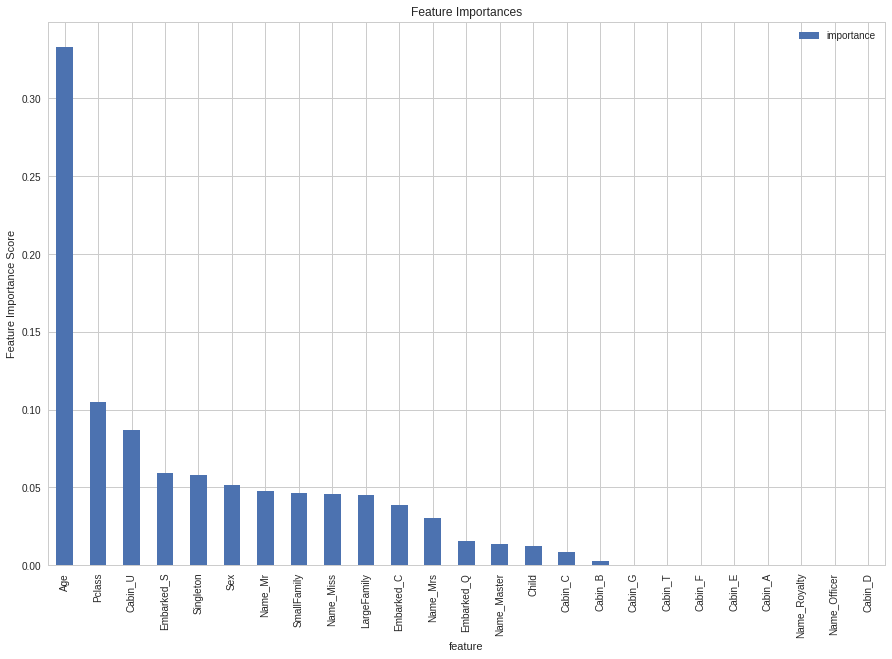

In [67]:
# (6) Reduce learning rate (1/10 learning rate)

xgb.set_params(n_estimators=5000, learning_rate=0.01)
xgb = modelfit(xgb, train_txf_df, train_txf_target)

print('Accuracy:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(xgb, train_txf_df, train_txf_target, scoring='f1')
xgb.fit(train_txf_df, train_txf_target)
plot_feature_importance(train_txf_df.columns, xgb.feature_importances_)

xgb

Confusion matrix, without normalization
[[495  54]
 [ 86 256]]


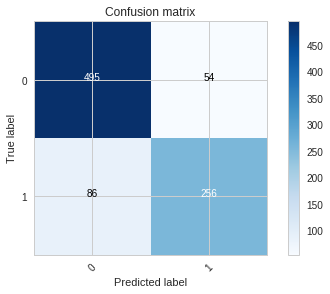

In [68]:
pred = xgb.predict(train_txf_df)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

- The submission score is 0.80861 (7/24) [63 features]
- Looks like RandomForest is not impacted by feature normalization, but XGBoost is indeed impacted by feature normalization.
- Revisit: the submission score is 0.79426 (7/27) [25 features]

## (3) GBM ([Gradient Boosting Hyperparameters tuning guide](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)) 

In [72]:
# (1) Start from suggested parameters & get n_estimators to get the baseline
#     - min_samples_split = 10 : This should be ~0.5-1% of total values.
#     - min_samples_leaf = 50 : used for preventing overfitting.
#     - max_depth = 6 : 5-8
#     - max_features = ‘sqrt’ 
#     - subsample = 0.8 : commonly used start value

gbm = GradientBoostingClassifier(learning_rate=0.1, 
                                 min_samples_split=10,
                                 min_samples_leaf=50,
                                 max_depth=6,
                                 max_features='sqrt',
                                 subsample=0.8,
                                 random_state=RANDOM_SEED)

parameter_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200]
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8226711560044894
  Best parameters: {'n_estimators': 175}
  [0.8114478 (+/-0.0476691) for {'n_estimators': 50}]
  [0.8193042 (+/-0.0622055) for {'n_estimators': 75}]
  [0.8181818 (+/-0.0552863) for {'n_estimators': 100}]
  [0.8204265 (+/-0.0572035) for {'n_estimators': 125}]
  [0.8181818 (+/-0.0482306) for {'n_estimators': 150}]
  [0.8226712 (+/-0.0622459) for {'n_estimators': 175}]
  [0.8204265 (+/-0.0640320) for {'n_estimators': 200}]
Accuracy
  CV Score : Mean - 0.8226831 | Std - 0.0310584 | Min - 0.7709497 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7526669 | Std - 0.04231345 | Min - 0.6962963 | Max - 0.8235294


In [73]:
# (2) Tune max_depth & min_samples_split

parameter_grid = {
    'max_depth': [5, 6, 7, 8], # 5 ~ 8
    'min_samples_split': [10, 25, 50, 75] # A smaller value for imbalanced class
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8249158249158249
  Best parameters: {'max_depth': 5, 'min_samples_split': 10}
  [0.8249158 (+/-0.0537693) for {'max_depth': 5, 'min_samples_split': 10}]
  [0.8249158 (+/-0.0537693) for {'max_depth': 5, 'min_samples_split': 25}]
  [0.8249158 (+/-0.0537693) for {'max_depth': 5, 'min_samples_split': 50}]
  [0.8249158 (+/-0.0537693) for {'max_depth': 5, 'min_samples_split': 75}]
  [0.8226712 (+/-0.0622459) for {'max_depth': 6, 'min_samples_split': 10}]
  [0.8226712 (+/-0.0622459) for {'max_depth': 6, 'min_samples_split': 25}]
  [0.8226712 (+/-0.0622459) for {'max_depth': 6, 'min_samples_split': 50}]
  [0.8226712 (+/-0.0622459) for {'max_depth': 6, 'min_samples_split': 75}]
  [0.8249158 (+/-0.0580336) for {'max_depth': 7, 'min_samples_split': 10}]
  [0.8249158 (+/-0.0580336) for {'max_depth': 7, 'min_samples_split': 25}]
  [0.8249158 (+/-0.0580336) for {'max_depth': 7, 'min_samples_split': 50}]
  [0.8249158 (+/-0.0580336) for {'max_depth': 7, 'min_samples_split': 

In [74]:
# (3) Tune min_samples_leaf

parameter_grid = {
    'min_samples_leaf': [5, 10, 25, 50] # A smaller value for imbalanced class
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8271604938271605
  Best parameters: {'min_samples_leaf': 10}
  [0.8181818 (+/-0.0787241) for {'min_samples_leaf': 5}]
  [0.8271605 (+/-0.0697958) for {'min_samples_leaf': 10}]
  [0.8249158 (+/-0.0654248) for {'min_samples_leaf': 25}]
  [0.8249158 (+/-0.0537693) for {'min_samples_leaf': 50}]
Accuracy
  CV Score : Mean - 0.8271714 | Std - 0.03483 | Min - 0.7765363 | Max - 0.8826816
F1:
  CV Score : Mean - 0.7589907 | Std - 0.05080976 | Min - 0.6969697 | Max - 0.8467153


In [75]:
parameter_grid = {
    'min_samples_leaf': [5, 10, 15, 20] # A smaller value for imbalanced class
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8271604938271605
  Best parameters: {'min_samples_leaf': 10}
  [0.8181818 (+/-0.0787241) for {'min_samples_leaf': 5}]
  [0.8271605 (+/-0.0697958) for {'min_samples_leaf': 10}]
  [0.8237935 (+/-0.0718458) for {'min_samples_leaf': 15}]
  [0.8237935 (+/-0.0676590) for {'min_samples_leaf': 20}]
Accuracy
  CV Score : Mean - 0.8271714 | Std - 0.03483 | Min - 0.7765363 | Max - 0.8826816
F1:
  CV Score : Mean - 0.7589907 | Std - 0.05080976 | Min - 0.6969697 | Max - 0.8467153


In [76]:
# (4) Tune max_features

parameter_grid = {
    'max_features': ['sqrt', 0.3]
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8305274971941639
  Best parameters: {'max_features': 0.3}
  [0.8271605 (+/-0.0697958) for {'max_features': 'sqrt'}]
  [0.8305275 (+/-0.0665039) for {'max_features': 0.3}]
Accuracy
  CV Score : Mean - 0.8305358 | Std - 0.03318465 | Min - 0.7765363 | Max - 0.877095
F1:
  CV Score : Mean - 0.7636074 | Std - 0.04722428 | Min - 0.6969697 | Max - 0.8405797


In [77]:
# (5) Tune subsample

parameter_grid = {
    'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]
}

gbm = get_best_cv_model(gbm, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

  KFold: 5
  Best score: 0.8316498316498316
  Best parameters: {'subsample': 0.6}
  [0.8316498 (+/-0.0694760) for {'subsample': 0.6}]
  [0.8215488 (+/-0.0682610) for {'subsample': 0.7}]
  [0.8249158 (+/-0.0686607) for {'subsample': 0.75}]
  [0.8305275 (+/-0.0665039) for {'subsample': 0.8}]
  [0.8226712 (+/-0.0821086) for {'subsample': 0.85}]
  [0.8282828 (+/-0.0692963) for {'subsample': 0.9}]
Accuracy
  CV Score : Mean - 0.8316784 | Std - 0.03466613 | Min - 0.7709497 | Max - 0.877095
F1:
  CV Score : Mean - 0.7655083 | Std - 0.04965748 | Min - 0.6870229 | Max - 0.8405797


Accuracy:
  CV Score : Mean - 0.823813 | Std - 0.03673167 | Min - 0.7597765 | Max - 0.8715084
F1:
  CV Score : Mean - 0.7553875 | Std - 0.05025238 | Min - 0.6766917 | Max - 0.8321168


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1750,
              presort='auto', random_state=0, subsample=0.6, verbose=0,
              warm_start=False)

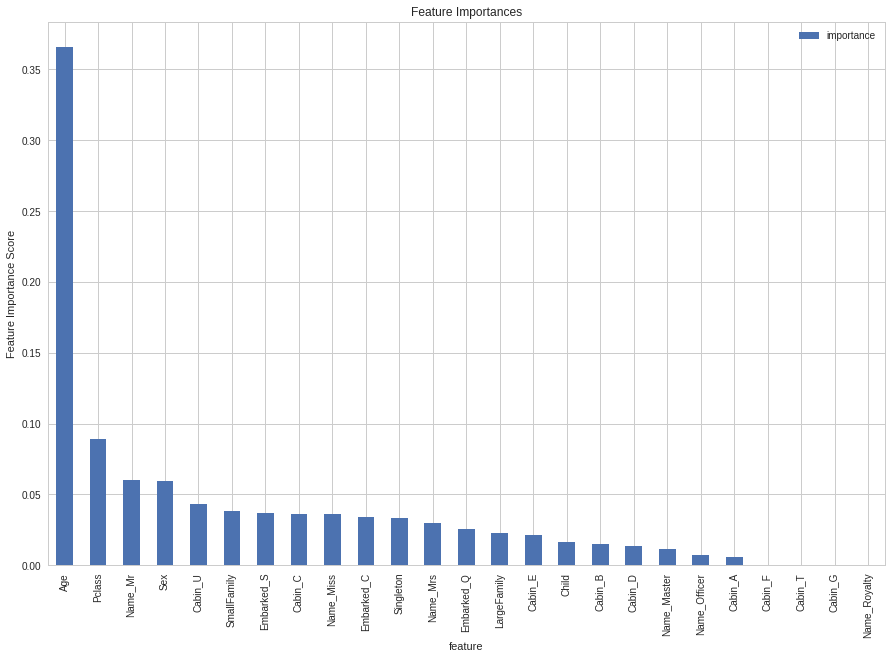

In [78]:
# (6) Reduce learning rate (1/10 learning rate), n_estimators x 10

count = gbm.get_params()['n_estimators']
gbm.set_params(n_estimators=count*10, learning_rate=0.01)

print('Accuracy:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(gbm, train_txf_df, train_txf_target, scoring='f1')

gbm.fit(train_txf_df, train_txf_target)
plot_feature_importance(train_txf_df.columns, gbm.feature_importances_)
gbm

Confusion matrix, without normalization
[[521  28]
 [ 80 262]]


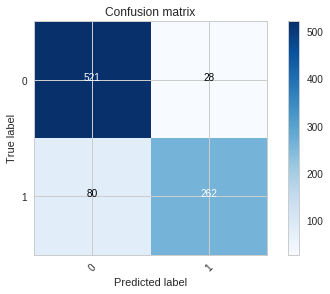

In [79]:
pred = gbm.predict(train_txf_df)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

- The submission score is 0.76077 (7/23) [63 features], kind of overfitting....
- Revisit: the submission score is 0.76555 (7/27) [25 features]

## (4) SVM

In [82]:
# Use default values

svc = SVC(random_state=RANDOM_SEED)

parameter_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.1, 0.01, 0.001]
}

svc = get_best_cv_model(svc, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=True)
print('Accuracy')
compute_cv_score(svc, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(svc, train_txf_df, train_txf_target, scoring='f1')

svc

  KFold: 5
  Best score: 0.8316498316498316
  Best parameters: {'C': 1, 'gamma': 0.1}
  [0.8103255 (+/-0.0716127) for {'C': 0.1, 'gamma': 0.1}]
  [0.6576880 (+/-0.0323484) for {'C': 0.1, 'gamma': 0.01}]
  [0.6161616 (+/-0.0031092) for {'C': 0.1, 'gamma': 0.001}]
  [0.8316498 (+/-0.0734256) for {'C': 1, 'gamma': 0.1}]
  [0.7946128 (+/-0.0676147) for {'C': 1, 'gamma': 0.01}]
  [0.6801347 (+/-0.0319068) for {'C': 1, 'gamma': 0.001}]
  [0.8204265 (+/-0.0835944) for {'C': 10, 'gamma': 0.1}]
  [0.8226712 (+/-0.0697266) for {'C': 10, 'gamma': 0.01}]
  [0.7890011 (+/-0.0720059) for {'C': 10, 'gamma': 0.001}]
Accuracy
  CV Score : Mean - 0.8316718 | Std - 0.03665053 | Min - 0.7653631 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7697491 | Std - 0.05047881 | Min - 0.6818182 | Max - 0.8208955


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

Confusion matrix, without normalization
[[492  57]
 [ 91 251]]


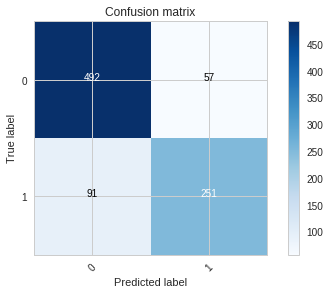

In [83]:
pred = svc.predict(train_txf_df)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

- The submission score is 0.78947 (7/23) [63 features]
- SVM seems to be also effected by feature normalization (0.73648 vs. 0.78947)
- Revisit: the submission score is 0.78947 (7/27) [25 features]

## (5) ExtraTreesClassifier

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 75, 'n_estimators': 100}
Accuracy
  CV Score : Mean - 0.8339128 | Std - 0.03519717 | Min - 0.7709497 | Max - 0.8715084
F1:
  CV Score : Mean - 0.7743483 | Std - 0.04762418 | Min - 0.6917293 | Max - 0.8270677


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=6, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=75,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

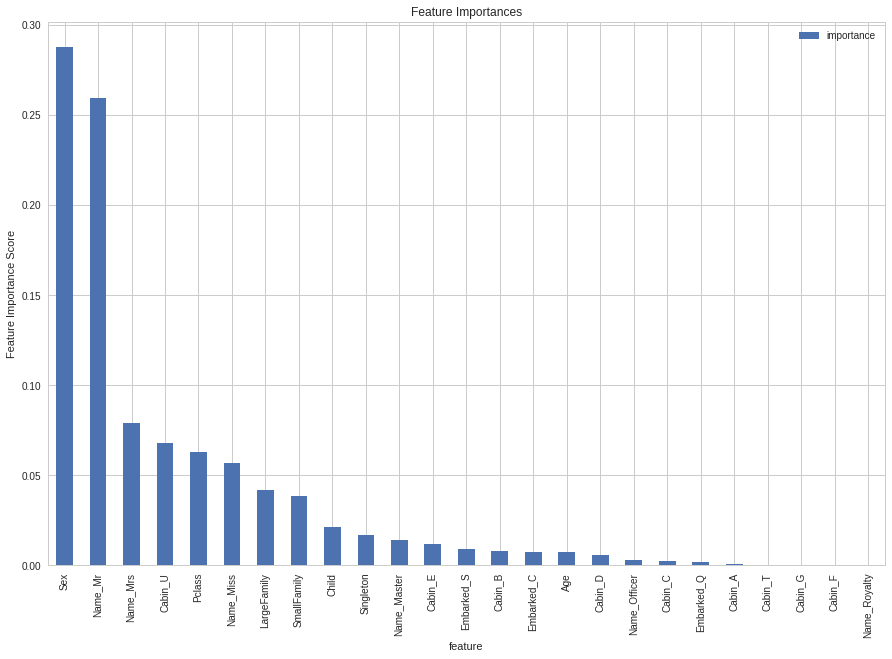

In [89]:
# tuning n_estimators, max_features and min_samples_split by cross-validated grid search

etc = ExtraTreesClassifier(min_samples_split=10,
                           min_samples_leaf=50,
                           max_depth=6,
                           max_features='sqrt',
                           random_state=RANDOM_SEED)

parameter_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_features': ['sqrt', 0.3],
    'min_samples_split': [10, 25, 50, 75],
    'min_samples_leaf': [5, 10, 25, 50]
}

etc = get_best_cv_model(etc, train_txf_df, train_txf_target, parameter_grid, scoring='accuracy', show=False)
print('Accuracy')
compute_cv_score(etc, train_txf_df, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(etc, train_txf_df, train_txf_target, scoring='f1')

etc.fit(train_txf_df, train_txf_target)
plot_feature_importance(train_txf_df.columns, etc.feature_importances_)
etc

Confusion matrix, without normalization
[[489  60]
 [ 87 255]]


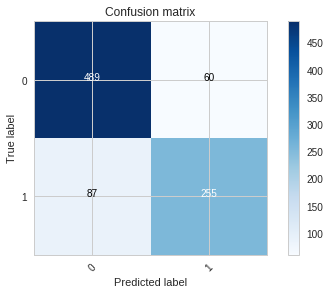

In [90]:
pred = etc.predict(train_txf_df)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

- The submisssion score is 0.79426 (7/23) [63 features]
- Revisit: the submission score is 0.79426 (7/27) [25 features]

## TODO: LightGBM

# Ensemble/Stacking
# Illustration ![](http://7xlo8f.com1.z0.glb.clouddn.com/blog-diagram-stacking.jpg)

In [94]:
from sklearn.model_selection import KFold

def get_stacker_dataset(X, y, T, n_folds, base_models):
    X = np.array(X)
    y = np.array(y)
    T = np.array(T)
        
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)        
    S_train = np.zeros((X.shape[0], len(base_models)))
    S_test = np.zeros((T.shape[0], len(base_models)))
    for i, clf in enumerate(base_models):
        S_test_i = np.zeros((T.shape[0], n_folds))
        for j, (train_idx, test_idx) in enumerate(kf.split(X, y)):
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_holdout = X[test_idx]

            clf.fit(X_train, y_train)
            S_train[test_idx, i] = clf.predict(X_holdout)[:]
            S_test_i[:, j] = clf.predict(T)[:]
            
        S_test[:, i] = S_test_i.mean(1).round()
        
    return S_train, S_test

def modelfit2(booster, dtrain, target, cv_folds=KFOLD, early_stopping_rounds=100):
    xgb_param = booster.get_xgb_params()
    xgtrain = xgboost.DMatrix(dtrain, label=target)
    cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=booster.get_params()['n_estimators'], 
                          nfold=cv_folds, seed=RANDOM_SEED, early_stopping_rounds=early_stopping_rounds)
    booster.set_params(n_estimators=cvresult.shape[0])
    print('n_estimators = %d'%cvresult.shape[0])
    return booster

In [96]:
from sklearn.base import clone

# Tuning stacker
stacker = clone(xgb)

rf_base = clone(rf)
xgb_base = clone(xgb)
etc_base = clone(etc)
svc_base = clone(svc)

base_models = [rf_base, xgb_base, etc_base, svc_base]
stack_train, stack_test = get_stacker_dataset(train_txf_df, train_txf_target, test_txf_df, KFOLD, base_models)
print(stack_train.shape, stack_test.shape)

# (1) get n_estimators
stacker = modelfit2(stacker, stack_train, train_txf_target, cv_folds=KFOLD)

(891, 4) (418, 4)
n_estimators = 130


In [100]:
# (2) Tune max_depth & min_child_weight
parameter_grid = {
    'max_depth': [3, 4, 5, 6, 7], # 3 ~ 10
    'min_child_weight': [5, 10, 25, 50] # A smaller value for imbalanced class
}
stacker = get_best_cv_model(stacker, stack_train, train_txf_target, parameter_grid, scoring='accuracy', show=False)

  KFold: 5
  Best score: 0.8260381593714927
  Best parameters: {'max_depth': 3, 'min_child_weight': 5}


In [101]:
# (3) Tune gamma
parameter_grid = {
    'gamma': [i/10.0 for i in range(0, 5)]
}
stacker = get_best_cv_model(stacker, stack_train, train_txf_target, parameter_grid, scoring='accuracy', show=False)

  KFold: 5
  Best score: 0.8260381593714927
  Best parameters: {'gamma': 0.0}


In [102]:
# Recalibrate the number of boosting rounds for the updated parameters.
# reset n_estimators to 1000 to get new n_estimators
stacker.set_params(n_estimators=1000)
stacker = modelfit2(stacker, stack_train, train_txf_target)

n_estimators = 32


In [103]:
# (4) Tune subsample and colsample_bytree
parameter_grid = {
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}
stacker = get_best_cv_model(stacker, stack_train, train_txf_target, parameter_grid, scoring='accuracy', show=False)

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'colsample_bytree': 0.6, 'subsample': 0.7}


In [104]:
parameter_grid = {
    'subsample': [0.65, 0.7, 0.75],
    'colsample_bytree': [0.55, 0.6, 0.65]
}
stacker = get_best_cv_model(stacker, stack_train, train_txf_target, parameter_grid, scoring='accuracy', show=False)

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'colsample_bytree': 0.55, 'subsample': 0.7}


In [105]:
# (5) Tuning Regularization Parameters
parameter_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
stacker = get_best_cv_model(stacker, stack_train, train_txf_target, parameter_grid, scoring='accuracy', show=False)

  KFold: 5
  Best score: 0.8338945005611672
  Best parameters: {'reg_alpha': 1e-05}


n_estimators = 32
Accuracy:
  CV Score : Mean - 0.8339191 | Std - 0.03445463 | Min - 0.7709497 | Max - 0.8659218
F1:
  CV Score : Mean - 0.7743168 | Std - 0.04674729 | Min - 0.6917293 | Max - 0.8208955
Confusion matrix, without normalization
[[489  60]
 [ 87 255]]


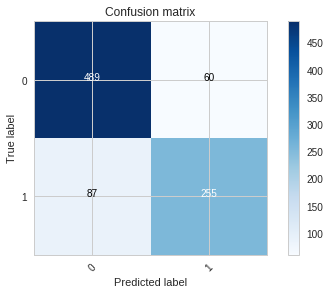

In [106]:
# (6) Reduce learning rate (1/10 learning rate)
stacker.set_params(n_estimators=5000, learning_rate=0.01)
stacker = modelfit2(stacker, stack_train, train_txf_target)

print('Accuracy:')
compute_cv_score(stacker, stack_train, train_txf_target, scoring='accuracy')
print('F1:')
compute_cv_score(stacker, stack_train, train_txf_target, scoring='f1')
stacker.fit(stack_train, train_txf_target)

pred = stacker.predict(stack_train)
cm = confusion_matrix(train_txf_target, pred)
plot_confusion_matrix(cm, [0, 1])

# final predictions
pred = stacker.predict(stack_test).astype(int)

- The submission score is 0.78947..... (7/23)
- Revisit: the submission score is 0.79426 (7/27)

# Ensemble/Averaging 

In [ ]:
# TODO

# Output Predictions

In [108]:
modelx = xgb

pred = modelx.predict(test_txf_df).astype(int)

df_output = pd.DataFrame()
aux = pd.read_csv("../input/test.csv")
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = pred
df_output[['PassengerId','Survived']].to_csv('titanic-0727-xgb-reduced.csv',index=False)

# Final Submission Score 